# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
# y = "health level" - predicted variable, dependent variable 
# x = "took the drug" - explanatory variable, independent variable 
# omitted variable == confounding variable

In [0]:
import random
random.seed(42) # Random seed for reproducibility
# dir(random)  # Reminding ourselves what we can do here

In [4]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [5]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [6]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [7]:
# Let's use crosstabulation to try to see what's going on
print(pd.crosstab(user_data['purchased'], user_data['time_on_site']).shape)
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

(2, 1000)


time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [10]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [11]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], 
            rownames=['device'], 
            colnames=["purchased", "time on site"], 
            normalize='index')

purchased               False                                        \
time on site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
device                                                                
False                0.148000              0.172              0.144   
True                 0.253333              0.260              0.100   

purchased                                                     True   \
time on site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
device                                                                
False                     0.092              0.148            0.016   
True                      0.000              0.000            0.136   

purchased                                                              \
time on site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
device                                                                  
False                  0.044000              0.072               0.08   
True                   0.162667              0.088               0.00   

purchased                        
time on site (480.819, 599.577]  
device                           
False                     0.084  
True                      0.000

In [12]:
help(user_data.plot)

Help on FramePlotMethods in module pandas.plotting._core object:

class FramePlotMethods(BasePlotMethods)
 |  DataFrame plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> df.plot.line()
 |  >>> df.plot.scatter('x', 'y')
 |  >>> df.plot.hexbin()
 |  
 |  These plotting methods can also be accessed by calling the accessor as a
 |  method with the ``kind`` argument:
 |  ``df.plot(kind='line')`` is equivalent to ``df.plot.line()``
 |  
 |  Method resolution order:
 |      FramePlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      pandas.core.accessor.DirNamesMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, font

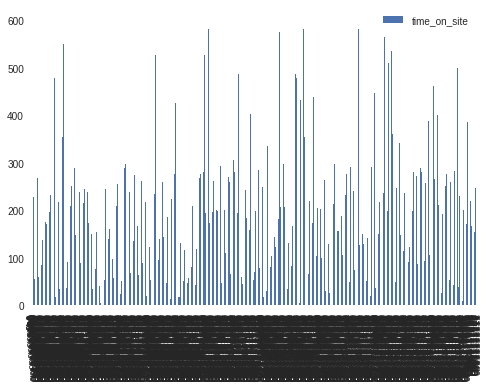

In [13]:
pd.pivot_table(
    user_data, values='time_on_site', index=bin).plot.bar();

In [14]:
pd.crosstab(user_data['mobile'], user_data['purchased'], time_bins, aggfunc=','.join)

purchased,False,True
mobile,,
False,"mobile,purchased,__dummy__","mobile,purchased,__dummy__"
True,"mobile,purchased,__dummy__","mobile,purchased,__dummy__"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22bf0e3668>,
      dtype=object)

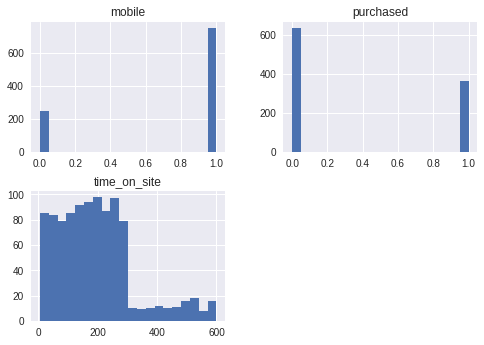

In [15]:
user_data.hist(bins=20)

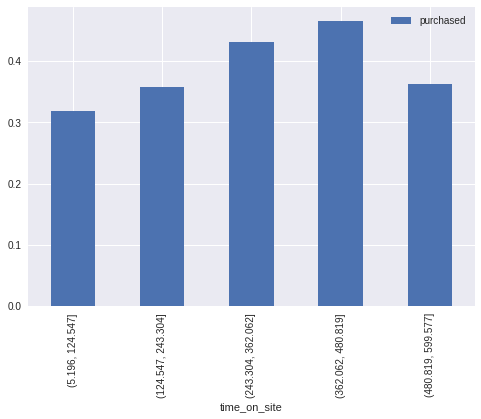

In [16]:
pd.pivot_table(user_data, values='purchased',
               index=time_bins).plot.bar()

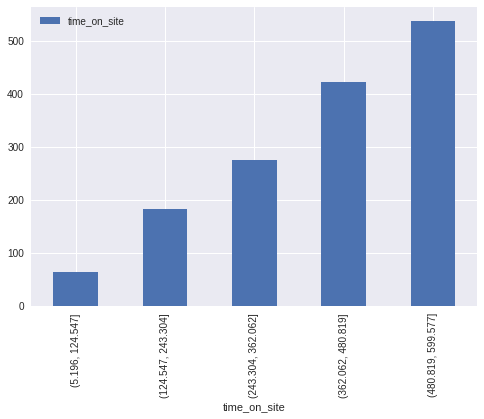

In [17]:
pd.pivot_table(
    user_data, values='time_on_site', index=time_bins).plot.bar();

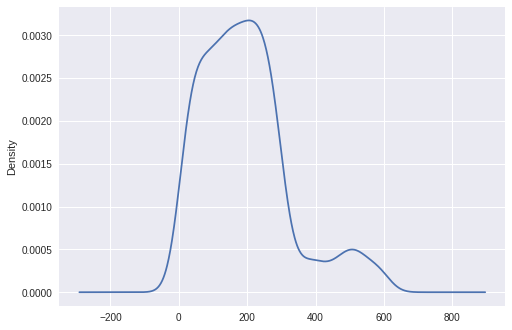

In [18]:
user_data['time_on_site'].plot.density()

In [19]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
print(type(ct))
ct

<class 'pandas.core.frame.DataFrame'>


purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(5.196, 124.547]    0.210227  0.413043  0.054054  0.351724
(124.547, 243.304]  0.244318  0.423913  0.148649  0.420690
(243.304, 362.062]  0.204545  0.163043  0.243243  0.227586
(362.062, 480.819]  0.130682  0.000000  0.270270  0.000000
(480.819, 599.577]  0.210227  0.000000  0.283784  0.000000

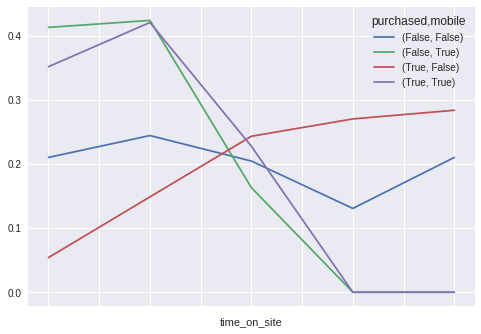

In [20]:
ct.plot()

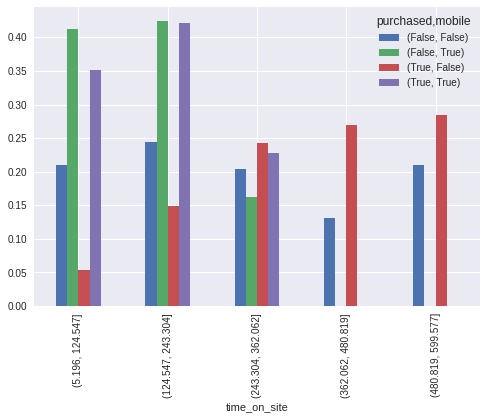

In [21]:
ct.plot(kind='bar')

In [22]:
ct2 = pd.crosstab(user_data['purchased'], [user_data['mobile'], time_bins],
                  normalize='columns')
ct2

mobile                  False                                        \
time_on_site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
purchased                                                             
False                0.902439           0.796296           0.666667   
True                 0.097561           0.203704           0.333333   

mobile                                                        True   \
time_on_site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
purchased                                                             
False                  0.534884           0.637931         0.650685   
True                   0.465116           0.362069         0.349315   

mobile                                                                 \
time_on_site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
purchased                                                               
False                  0.615142           0.531915                0.0   
True                   0.384858           0.468085                0.0   

mobile                           
time_on_site (480.819, 599.577]  
purchased                        
False                       0.0  
True                        0.0

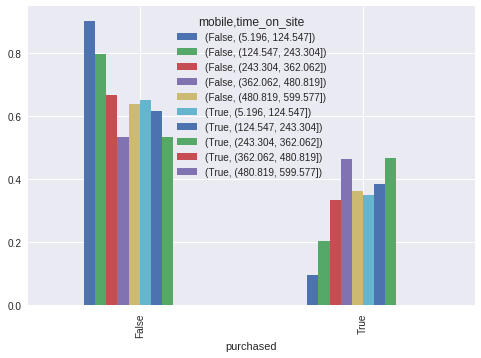

In [23]:
ct2.plot(kind='bar')

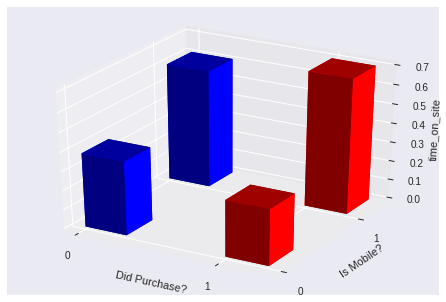

In [24]:
# Trying 3D barplot courtesy of Cole
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data? They are all integers and continuous except the id 
2.  What are the relationships between the variables? If workout time is high your weight will be closer to the norm, if your age is low you weight is more likely to be lower. 
3.  Which relationships are "real", and which spurious? workout time with weight are real. I can't say with very much certainty if any of the other relationships are real


In [61]:
Persons = pd.read_csv('https://raw.githubusercontent.com/PWalis/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv', na_values=["?"])
print(Persons.isnull().sum())
Persons = Persons.rename( {'Unnamed: 0':'id'}, axis='columns')
Persons.head()
# Persons.exercise_time.describe()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64


,id,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
time_bins = pd.cut(Persons['exercise_time'], 4)
weight_bins = pd.cut(Persons['weight'], 3)
age_bins = pd.cut(Persons['age'],5)

In [109]:
ct_persons = pd.crosstab(weight_bins, [time_bins, age_bins], rownames=['Weight'], colnames=['Time Exercised', 'Age'], normalize='columns')
ct_persons1 = pd.crosstab(time_bins, [age_bins, weight_bins], rownames=['Time Exercised'], colnames=['Age', 'Weight'], normalize='columns')
ct_persons2 = pd.crosstab(age_bins, [time_bins, weight_bins], rownames=['Age'], colnames=['Time Exercised', 'Weight'], normalize='columns')
ct_persons2.head()

Time Exercised      (-0.3, 75.0]                                      \
Weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]   
Age                                                                    
(17.938, 30.4]          0.198198           0.173228         0.170940   
(30.4, 42.8]            0.162162           0.149606         0.179487   
(42.8, 55.2]            0.126126           0.181102         0.102564   
(55.2, 67.6]            0.153153           0.181102         0.239316   
(67.6, 80.0]            0.360360           0.314961         0.307692   

Time Exercised     (75.0, 150.0]                                      \
Weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]   
Age                                                                    
(17.938, 30.4]          0.173228           0.180645         0.112903   
(30.4, 42.8]            0.228346           0.161290         0.177419   
(42.8, 55.2]            0.141732           0.135484         0.241935   
(55.2, 67.6]            0.181102           0.187097         0.225806   
(67.6, 80.0]            0.275591           0.335484         0.241935   

Time Exercised    (150.0, 225.0]                                      \
Weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]   
Age                                                                    
(17.938, 30.4]          0.277108           0.290323              0.5   
(30.4, 42.8]            0.246988           0.204301              0.5   
(42.8, 55.2]            0.156627           0.204301              0.0   
(55.2, 67.6]            0.216867           0.182796              0.0   
(67.6, 80.0]            0.102410           0.118280              0.0   

Time Exercised    (225.0, 300.0]                                      
Weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]  
Age                                                                   
(17.938, 30.4]          0.247423           0.282609              0.0  
(30.4, 42.8]            0.288660           0.282609              0.0  
(42.8, 55.2]            0.345361           0.173913              0.0  
(55.2, 67.6]            0.118557           0.260870              0.0  
(67.6, 80.0]            0.000000           0.000000              0.0

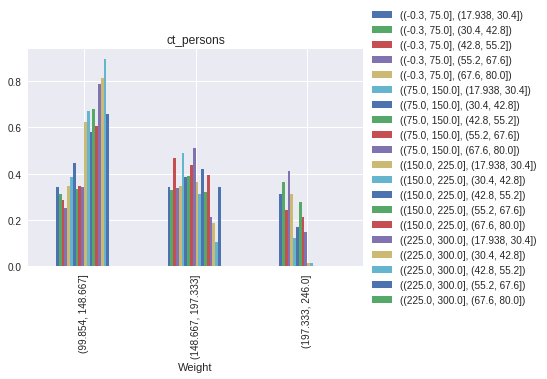

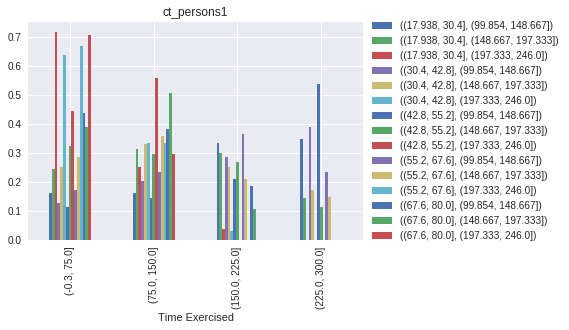

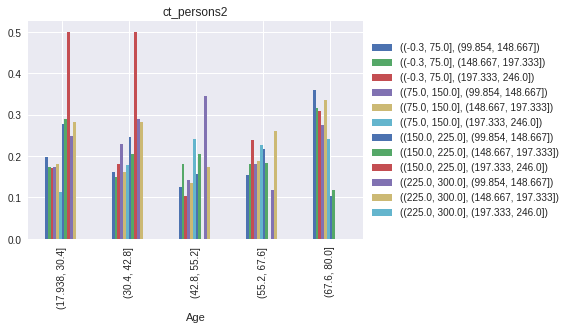

count    1200.000000
mean      153.540833
std        35.132182
min       100.000000
25%       125.000000
50%       149.000000
75%       180.250000
max       246.000000
Name: weight, dtype: float64


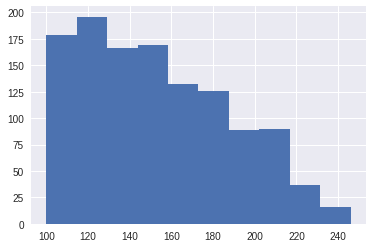

In [103]:
ct_persons.plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))
plt.title('ct_persons')
plt.show()
ct_persons1.plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))
plt.title('ct_persons1')
plt.show()
ct_persons2.plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))
plt.title('ct_persons2')
plt.show()
print(Persons.weight.describe())
Persons.weight.hist()

# These graphs took me a little bit of analysing until I kinda understood what they were saying

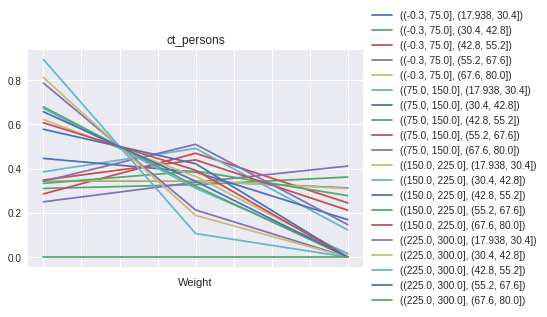

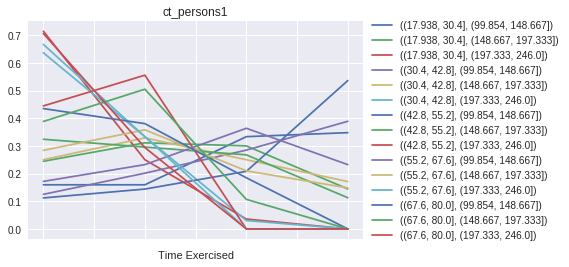

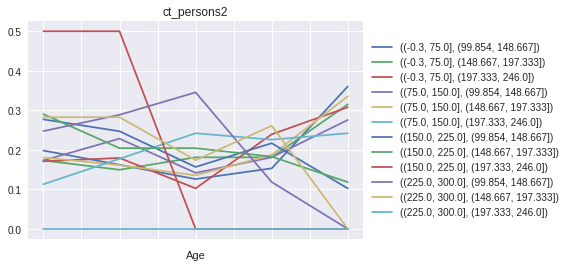

In [104]:
ct_persons.plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))
plt.title('ct_persons')
plt.show()
ct_persons1.plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))
plt.title('ct_persons1')
plt.show()
ct_persons2.plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))
plt.title('ct_persons2')
plt.show()

# These line graphs don't make much sense to me, the colors repeat which isn't helpful 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)